In [1]:
import gc
import os
import string

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchinfo import summary

from collections import namedtuple
import PyPDF3

In [2]:
jtplot.style("gruvboxd")

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
SEED = 42

if device == "cuda":
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

In [6]:
DATA_DIR = os.getcwd().replace('notebooks', 'data')

with open(os.path.join(DATA_DIR, 'anna.txt'), 'r') as file:
    text = file.read()

In [7]:
text[:120]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

In [8]:
unique_chars = list(set(text))

In [9]:
len(unique_chars)

83

In [10]:
unique_chars

['h',
 ';',
 'v',
 '"',
 'J',
 'f',
 'R',
 'D',
 'G',
 'u',
 'j',
 'F',
 'a',
 'r',
 '6',
 '&',
 'O',
 'q',
 'b',
 'g',
 'Q',
 '2',
 'X',
 ')',
 '/',
 's',
 'N',
 'H',
 '8',
 'x',
 '9',
 '`',
 '3',
 'l',
 '%',
 '4',
 'o',
 'z',
 'U',
 'B',
 '*',
 'M',
 'Z',
 'P',
 'C',
 '0',
 '(',
 'm',
 '_',
 '-',
 'Y',
 'L',
 'W',
 'd',
 'A',
 't',
 "'",
 'w',
 'T',
 'i',
 'y',
 '7',
 'k',
 ' ',
 '?',
 'c',
 '@',
 'I',
 'p',
 '\n',
 'S',
 'E',
 'V',
 '1',
 '!',
 'e',
 '5',
 'K',
 '$',
 ',',
 'n',
 '.',
 ':']

In [11]:
chars2int = {char : unique_chars.index(char) for char in unique_chars}
int2char = {v : k for (k, v) in chars2int.items()}

In [12]:
def encode_text(text, unique_chars = None, extend = False):
    result_tuple = namedtuple('results', ['encoded_text', 'unique_char', 'int2char', 'char2int'])
    
    if unique_chars is None:
        unique_chars = list(set(text))
    else:
        if extend:
            unique_chars.extend(list('#[]{}+-*=!'))
        
    char2int = {char : unique_chars.index(char) for char in unique_chars}
    int2char = {v : k for (k, v) in char2int.items()}
    
    encoded_text = np.array(list(map(lambda x: char2int[x], list(text))))
    
    return result_tuple(encoded_text, unique_chars, int2char, char2int)

In [13]:
train_frac = 0.8
text, val_text = text[:int(len(text)*train_frac)], text[int(len(text)*(train_frac)):]

In [14]:
encoded_text, unique_chars, int2char, char2int = encode_text(text, unique_chars)

In [15]:
def one_hot_convert(arr, n_labels):
    nrows = arr.size
    array = np.zeros(shape = [nrows, n_labels])
    array[np.arange(array.shape[0]), arr.flatten()] = 1.
    
    return array

In [16]:
one_hot_convert(np.array([[1, 2, 3, 5]]), 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [17]:
batch_size = 32
seq_length = 16

In [18]:
numel_seq = batch_size * seq_length

In [19]:
numel_seq

512

In [20]:
encoded_text.shape[0]/numel_seq

3101.91015625

In [21]:
def batch_sequence(arr, batch_size, seq_length):
    numel_seq = batch_size * seq_length
    num_batches = arr.size // numel_seq
    
    arr = arr[: num_batches * numel_seq].reshape(batch_size, -1)
    #print(arr.shape)
    
    batched_data = [(arr[:, n : n + seq_length], arr[:, n + 1 : n + 1 + seq_length])
                    for n in range(0, arr.shape[1], seq_length)]
    
    ### Finalize final array size
    batched_data[-1] = (batched_data[-1][0],
                        np.append(batched_data[-1][1], batched_data[0][1][:, 0].reshape(-1, 1), axis = 1))
    
    ###batched_arr = [arr[n : n + numel_seq].reshape(batch_size, seq_length) for n in range(num_batches)]
    return iter(batched_data), num_batches

In [22]:
batch, _ = batch_sequence(encoded_text, 32, 16)

In [23]:
X, y = next(batch)

In [24]:
X

array([[44,  0, 12, 68, 55, 75, 13, 63, 73, 69, 69, 69, 27, 12, 68, 68],
       [75, 63,  0, 12, 53, 63,  5, 36, 13, 19, 36, 55, 55, 75, 80, 63],
       [55, 13, 12, 19, 75, 53, 60, 63, 59, 80, 69, 59, 55, 81,  3, 69],
       [55, 63,  0, 75, 13, 63, 57, 59, 55,  0, 63, 47, 75, 79, 63, 12],
       [75, 59, 13, 63,  0, 36, 25, 55, 69, 25, 47, 59, 33, 75, 53, 63],
       [75, 55, 75, 13, 25, 18,  9, 13, 19, 79, 63, 12, 25, 63, 25, 36],
       [25,  0, 75, 63, 57,  0, 59, 25, 68, 75, 13, 75, 53, 63, 68, 75],
       [ 5, 13, 36, 47, 63,  0, 75, 13, 63, 55, 36, 80, 75, 63, 55,  0],
       [ 5, 36, 13, 75, 81, 69, 69,  3, 27, 12,  2, 75, 63, 60, 36,  9],
       [57, 12, 25, 63, 65, 36, 47, 68, 33, 75, 55, 75, 33, 60, 63, 12],
       [75, 63, 54, 33, 75, 29, 75, 60, 63, 54, 33, 75, 29, 12, 80, 53],
       [ 0, 12, 53, 63,  5, 75, 33, 55, 63, 12, 55, 63, 59, 55, 81, 63],
       [68, 63, 55,  0, 75, 63, 33, 12, 25, 55, 63, 33, 59, 80, 75, 79],
       [60, 63, 57,  0, 59, 65,  0, 63, 65,  0, 59,

In [25]:
y

array([[ 0, 12, 68, 55, 75, 13, 63, 73, 69, 69, 69, 27, 12, 68, 68, 60],
       [63,  0, 12, 53, 63,  5, 36, 13, 19, 36, 55, 55, 75, 80, 63, 55],
       [13, 12, 19, 75, 53, 60, 63, 59, 80, 69, 59, 55, 81,  3, 69, 69],
       [63,  0, 75, 13, 63, 57, 59, 55,  0, 63, 47, 75, 79, 63, 12, 80],
       [59, 13, 63,  0, 36, 25, 55, 69, 25, 47, 59, 33, 75, 53, 63, 12],
       [55, 75, 13, 25, 18,  9, 13, 19, 79, 63, 12, 25, 63, 25, 36, 36],
       [ 0, 75, 63, 57,  0, 59, 25, 68, 75, 13, 75, 53, 63, 68, 75, 80],
       [13, 36, 47, 63,  0, 75, 13, 63, 55, 36, 80, 75, 63, 55,  0, 12],
       [36, 13, 75, 81, 69, 69,  3, 27, 12,  2, 75, 63, 60, 36,  9, 63],
       [12, 25, 63, 65, 36, 47, 68, 33, 75, 55, 75, 33, 60, 63, 12, 33],
       [63, 54, 33, 75, 29, 75, 60, 63, 54, 33, 75, 29, 12, 80, 53, 13],
       [12, 53, 63,  5, 75, 33, 55, 63, 12, 55, 63, 59, 55, 81, 63, 27],
       [63, 55,  0, 75, 63, 33, 12, 25, 55, 63, 33, 59, 80, 75, 79, 63],
       [63, 57,  0, 59, 65,  0, 63, 65,  0, 59, 33,

In [26]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [27]:
len(unique_chars)

83

In [28]:
#X_ = one_hot_convert(X, 90)
X_ = one_hot_encode(X, len(unique_chars))

In [29]:
X.shape

(32, 16)

In [30]:
X_.shape

(32, 16, 83)

\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

In [31]:
print(help(nn.LSTM))

Help on class LSTM in module torch.nn.modules.rnn:

class LSTM(RNNBase)
 |  LSTM(*args, **kwargs)
 |  
 |  Applies a multi-layer long short-term memory (LSTM) RNN to an input
 |  sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
 |          c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
 |          h_t = o_t \odot \tanh(c_t) \\
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
 |  state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{t-1}`
 |  is the hidden state of the layer at time `t-1` or the initial hidden
 |  state a

In [32]:
def get_text(fpath, start_page = 1):
    with open(fpath, "rb") as f:
        pdf = PyPDF3.PdfFileReader(f)
        text = str()
        for page_num in range(start_page-1, pdf.numPages):
            page = pdf.getPage(page_num)
            text = text + ' ' + page.extractText()
    return text.lower()

In [33]:
len(text)

1588178

In [34]:
len(val_text)

397045

In [35]:
print(val_text[:1000])

at it may be, but still it ought to be treated a little more
respectfully. Snetkov, now.... We may be of use, or we may not, but
we're the growth of a thousand years. If we're laying out a garden,
planning one before the house, you know, and there you've a tree that's
stood for centuries in the very spot.... Old and gnarled it may be, and
yet you don't cut down the old fellow to make room for the flowerbeds,
but lay out your beds so as to take advantage of the tree. You won't
grow him again in a year," he said cautiously, and he immediately
changed the conversation. "Well, and how is your land doing?"

"Oh, not very well. I make five per cent."

"Yes, but you don't reckon your own work. Aren't you worth something
too? I'll tell you my own case. Before I took to seeing after the land,
I had a salary of three hundred pounds from the service. Now I do more
work than I did in the service, and like you I get five per cent. on the
land, and thank God for that. But one's work is thrown in for

In [36]:
### Encode validation data
encoding_results = encode_text(val_text, unique_chars)
encoded_val = encoding_results.encoded_text

In [37]:
unique_char = encoding_results.unique_char
len(unique_char)

83

\begin{aligned}
 |              N ={} & \text{batch size} \\
 |              L ={} & \text{sequence length} \\
 |              D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
 |              H_{in} ={} & \text{input\_size} \\
 |              H_{cell} ={} & \text{hidden\_size} \\
 |              H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
 |          \end{aligned}

In [38]:
import torch
from torch import nn

class CharRNN(nn.Module):
    """
    Character-level LSTM.
    
    Parameters
    ----------
    input_size:
        Input (feature sze) for RNN.
    output_size:
        Input (feature sze) for RNN.
    hidden_size:
        Number of output features for RNN.
    dropout_rate:
        Dropout probability for RNN.
    batch_size:
        Number of sequences in a batch.
    D:
        Number of directions: uni- or bidirectional architecture for RNN.
    num_layers:
        Number of RNN stacks.
    batch_size:
        Number of sequences in a batch.
    
    Returns
    -------
    output:
        Shape: [batch_size, sequence_length, num_features]
    hidden_state:
        Tuple containing:
        - Short-term hidden state
            Shape: [batch_size, sequence_length, num_features]
        - Cell state
            Shape: [batch_size, sequence_length, num_features]
    
    """
    def __init__(self, input_size = 32, hidden_size = 128, dropout = 0.25,
                 batch_size = 32, D = 1, num_layers = 2, output_size = 32, base_rnn = nn.LSTM):
        
        super(CharRNN, self).__init__()
        
        self.base_rnn = base_rnn
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = D
        
        self.rnn = self.base_rnn(input_size = self.input_size, hidden_size = self.hidden_size,
                                dropout = self.dropout_rate, batch_first = True,
                                bidirectional = True if self.D == 2 else False, bias = True,
                                num_layers = self.num_layers)
        
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.D*self.hidden_size, self.output_size)
        
    def forward(self, x, hidden_state):
        outputs, hidden_state = self.rnn(x, hidden_state)
        outputs = self.dropout(outputs)
        outputs = outputs.contiguous().view(-1, self.D*self.hidden_size)
        outputs = self.fc(outputs)
        
        return outputs, hidden_state
    
    def init_hidden_state(self, mean = 0, stddev = 0):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
        h = h.to(device)
        
        if self.base_rnn == nn.LSTM:
            c = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
            c = c.to(device)
            h = (h, c)
        
        return h

In [39]:
batch_size = 128
seq_length = 100
num_layers = 2
hidden_size = 512

max_norm = 15
epochs = 30
lr = 1e-3

In [40]:
model = CharRNN(D = 1, dropout = 0.5, num_layers = num_layers, base_rnn = nn.LSTM,
                batch_size = batch_size, hidden_size = hidden_size,
                input_size = len(unique_char), output_size = len(unique_char)).to(device)

In [41]:
print(model)

CharRNN(
  (rnn): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [42]:
### Objective functions and optimizer
opt = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [43]:
gc.collect()

11

In [44]:
### Train data
_, num_batches = batch_sequence(encoded_text, batch_size, seq_length)

In [45]:
### Validation data
_, num_batches_ = batch_sequence(encoded_val, batch_size, seq_length)

In [46]:
### Num of train batches
print(num_batches)

124


In [47]:
### Num of valid batches
print(num_batches_)

31


In [48]:
running_train_loss = list()
running_val_loss = list()

### Outer training loop
for epoch in range(1, epochs + 1):
    h = model.init_hidden_state(mean = 0., stddev = .5)
    iteration = 0
    train_losses = list()
    
    ### Inner training loop
    for X, y in batch_sequence(encoded_text, batch_size, seq_length)[0]:
        X = one_hot_encode(X, len(unique_char))
        X, y = torch.as_tensor(X).to(device), torch.as_tensor(y).to(device)
        
        model.train()
        iteration += 1
        
        h = tuple([each.data for each in h])
        opt.zero_grad()
        
        outputs, h = model(X, h)
        
        loss = criterion(outputs, y.reshape(-1,).long())
        
        loss.backward(retain_graph = True)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        
        train_losses.append(loss.detach().cpu().item())
        
        ### Outer validation loop
        if (not iteration % 20) or (iteration == num_batches):
            i = 0
            val_losses = list()
            model.eval()
            val_h = model.init_hidden_state(mean = 0., stddev = .5)
            
            ### Inner validation loop
            with torch.inference_mode():
                for X_, y_ in batch_sequence(encoded_val, batch_size, seq_length)[0]:
                    i += 1

                    val_h = tuple([each.data for each in val_h])

                    X_ = torch.as_tensor(one_hot_encode(X_, len(unique_chars))).to(device)
                    y_ = torch.as_tensor(y_).to(device)

                    outputs_, val_h = model(X_, val_h)

                    val_loss = criterion(outputs_, y_.reshape(-1,).long())
                    val_losses.append(val_loss.detach().cpu().item())

                ### Report training and validation losses
                val_loss = torch.Tensor(val_losses).mean().item()

                train_loss = torch.Tensor(train_losses).mean().item()
            
            running_train_loss.append(train_loss)
            running_val_loss.append(val_loss)
            
            print('='*80+"\n")
            print(f'Epoch: {epoch}/{epochs}, Iteration {iteration}/{num_batches},',
                  f'Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
    print('\n'+'='*80)
    print('='*80)
    print('='*80)
    #print('='*60)
    #print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}\n')
    #print('='*60)


Epoch: 1/30, Iteration 20/124, Train Loss: 3.4760, Valid Loss: 3.1454

Epoch: 1/30, Iteration 40/124, Train Loss: 3.3077, Valid Loss: 3.1203

Epoch: 1/30, Iteration 60/124, Train Loss: 3.2459, Valid Loss: 3.1168

Epoch: 1/30, Iteration 80/124, Train Loss: 3.2121, Valid Loss: 3.1077

Epoch: 1/30, Iteration 100/124, Train Loss: 3.1859, Valid Loss: 3.0591

Epoch: 1/30, Iteration 120/124, Train Loss: 3.1571, Valid Loss: 2.9443

Epoch: 1/30, Iteration 124/124, Train Loss: 3.1502, Valid Loss: 2.8989


Epoch: 2/30, Iteration 20/124, Train Loss: 2.8507, Valid Loss: 2.7618

Epoch: 2/30, Iteration 40/124, Train Loss: 2.7619, Valid Loss: 2.5748

Epoch: 2/30, Iteration 60/124, Train Loss: 2.6895, Valid Loss: 2.4771

Epoch: 2/30, Iteration 80/124, Train Loss: 2.6330, Valid Loss: 2.4172

Epoch: 2/30, Iteration 100/124, Train Loss: 2.5882, Valid Loss: 2.3556

Epoch: 2/30, Iteration 120/124, Train Loss: 2.5499, Valid Loss: 2.3092

Epoch: 2/30, Iteration 124/124, Train Loss: 2.5426, Valid Loss: 2.2924

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


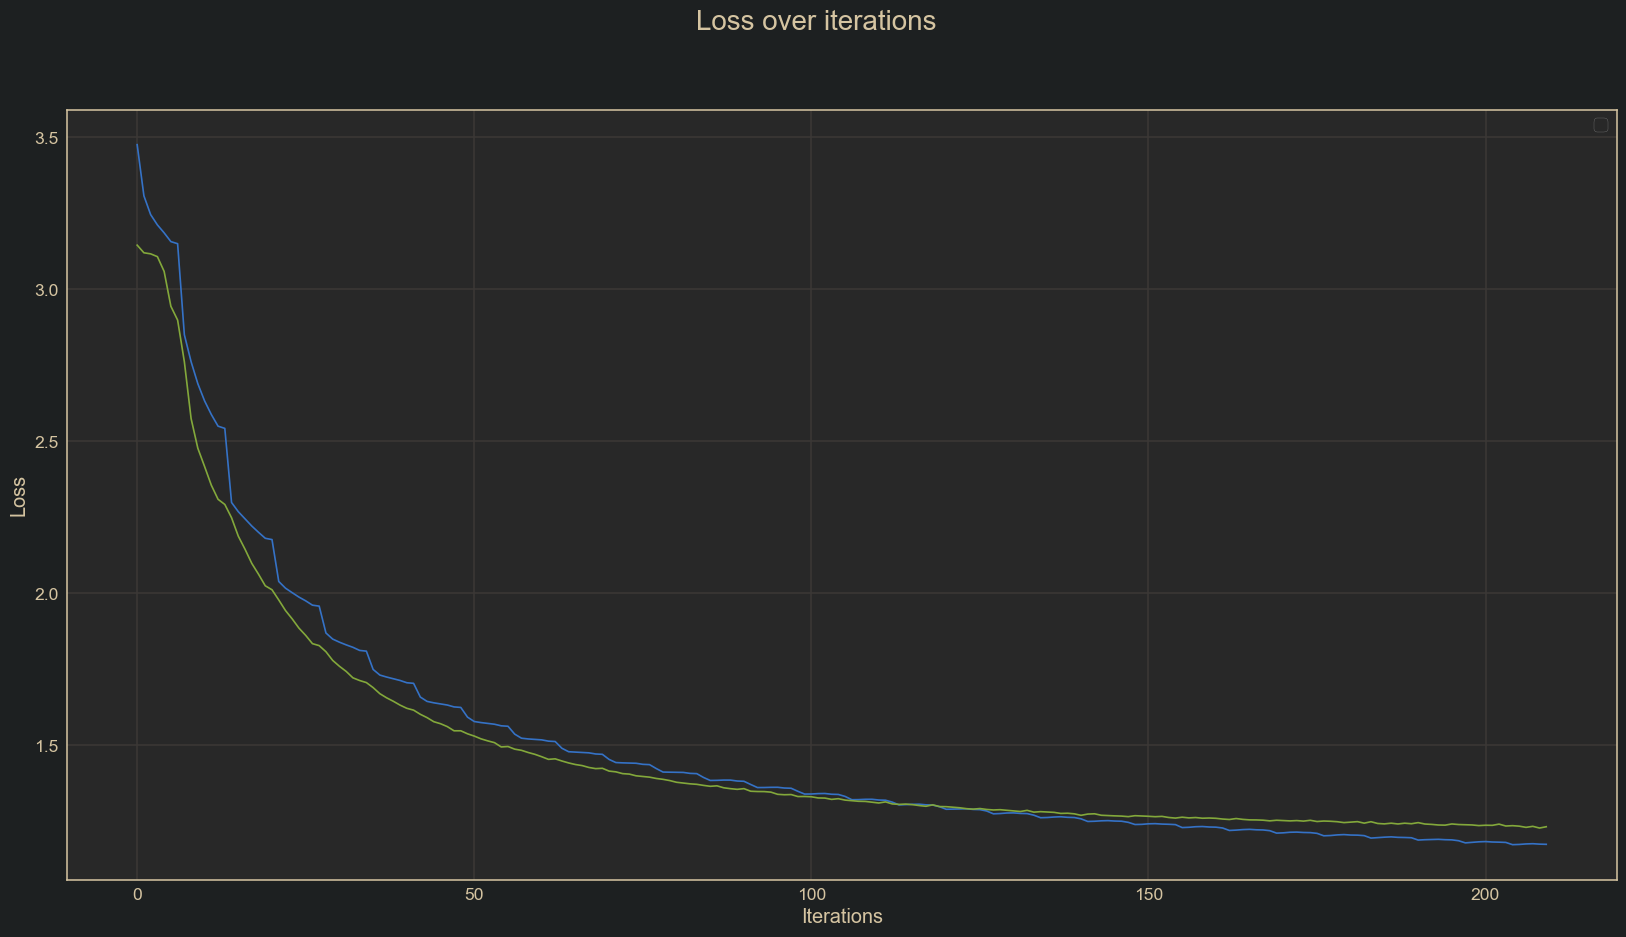

In [49]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(running_train_loss)), running_train_loss, range(len(running_val_loss)), running_val_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.suptitle("Loss over iterations", fontsize = 20)
plt.legend()
plt.show(); plt.close("all")

In [50]:
### Freeze model weights
model.requires_grad_ = False

In [51]:
int2char = encoding_results.int2char
char2int = encoding_results.char2int

In [52]:
seed = "Lan al'Mandragoran went up the mountain"
k = 5

In [53]:
def predict(x, h, net, k = 5):
    x = np.array([[char2int[x]]])
    x = one_hot_encode(x, len(unique_chars))
    x = torch.from_numpy(x).to(device).contiguous()
    
    out, h = net(x, h)
    p = F.softmax(out, dim = -1).data
    p, chars = p.topk(k, dim = -1)
    
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    
    return np.random.choice(chars, p = p/p.sum()), h

In [54]:
a = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_()
b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_()
h = (a.to(device), b.to(device))

predict("D", h, model, 5)

(59,
 (tensor([[[ 0.0344, -0.3489, -0.0471,  ...,  0.0650,  0.1803, -0.1723]],
  
          [[-0.0211,  0.4152, -0.0334,  ..., -0.1460, -0.3382,  0.0301]]],
         device='cuda:0', grad_fn=<CudnnRnnBackward0>),
  tensor([[[ 0.0748, -0.5523, -0.0759,  ...,  0.1373,  0.2702, -0.3255]],
  
          [[-0.0360,  0.7932, -0.1024,  ..., -0.1592, -0.5809,  0.0992]]],
         device='cuda:0', grad_fn=<CudnnRnnBackward0>)))

In [55]:
def prime_model(model, seed, k):
    seed_list = list(seed)

    h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
    if model.base_rnn == nn.LSTM:
        b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
        h = (h.to(device), b.to(device))

    for char in seed_list:
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        next_char, h = predict(char, h, model, k)

    seed_list.append(int2char[next_char])

    return seed_list, h

seed_list = list(seed)

a = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
h = (a.to(device), b.to(device))

for char in seed_list:
    h = tuple([each.data for each in h])
    next_char, h = predict(char, h, model, k)

seed_list.append(int2char[next_char])
seed_list_1 = seed_list.copy()
seed_list_2 = seed_list.copy()

In [56]:
first_seed_list, h = prime_model(model, seed, k)

In [57]:
print(''.join(first_seed_list))

Lan al'Mandragoran went up the mountain 


In [58]:
## Method 1
for ii in range(1000):
    h = tuple([each.data for each in h])
    next_char, h = predict(first_seed_list[-1], h, model, k)
    first_seed_list.append(int2char[next_char])

In [59]:
seed = "Why would you imagine that"

second_seed_list, h = prime_model(model, seed, k)

In [60]:
## Method 2
for ix in range(1000):
    h = tuple([each.data.to(device) for each in h])
    x = np.array(char2int[second_seed_list[-1]]).reshape(1, -1)
    x = one_hot_encode(x, len(unique_char))
    x = torch.tensor(x).to(device)
    out, h = model(x, h)
    
    p = F.softmax(out, dim=-1)
    p, chars = p.topk(k = k, dim=-1)
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    second_seed_list.append(int2char[np.random.choice(chars, p = p/p.sum())])
    #next_char = chars[torch.distributions.Uniform(low = 0, high = k).sample().to(torch.int32).item()].item()
    #seed_list.append(int2char[next_char])
    

In [61]:
### First generated text sample
first_pred_text = ''.join(first_seed_list)

In [62]:
print(first_pred_text)

Lan al'Mandragoran went up the mountain of what
she was
talking to the same time.
However which he had sent it. That we heard it seemed in a carriage.

He could not have seemed. He felt all the country,
half all the same start. But the sidelong people was
aware of it. And again there would come and hat, which
he went to her, so that
his bride, so at the same and was a man after this soul in his shook he would
consider him over the cause of the crowd
of talking of it, began smaking the beauty. The
children would by a low starm to begin all at them. He felt that it
was
the one
thought of what was surrounded by him in the priest of the second and
he
were saying that it was as it is so little finished, with a creature as though hid the person angry. But how they were the
position
of the success with the child and had saw that she.. And when he had not seen her husband.

"I see it was all out of the children in happiness in
the words."

"Oh, told you see that," said Varenka and a man with a

In [63]:
### Second generated text sample
second_pred_text = ''.join(second_seed_list)

In [64]:
print(second_pred_text)

Why would you imagine that he will be to
see him. But when the point, the people's
correct of that, all, was in the same torture, a strein was so
profising it. She went into the streem
and the
mertimiticiliticase property.
He stoud on a beal than the counting a smile of all his servant to see a contempt of
woman, there was surpore to him, but the children were
sitting. She could not help her hundred in side train. And he would not say something to her.



Chapter 32


The dirnce and the said that to be that the old minute it had to told her an instant to have
been a little bad, and with a part of his face which
he came to her horse. Both though he was considered
it.

"Well, so, your mother. Alone won't you see through?
You're sitting deal.

And your happy's a man and then. I'll see to the
position of his shall be drive about."

"No, way a little thing. I was to be tender, then
I should be the second time that it's over to take
a sense of he called into
some possession, and what is the 